In this notebook, we show how you can generate templates of signals and backgrounds. More specifically, you will see how to:
- Use the published XENONnT detector response model based on our YBe-calibrated yield models, and generate signal templates of your own new physics model to search for.
- Use the published XENONnT detector response model based on your own yield models, and generate signal and background templates based on the new yield models.
- Use the published XENONnT detector response model based on your own yield models, and generate signal templates of your own new physics model to search for, together with the corresponding background models.

In [1]:
import numpy as np
import os
import json
from tqdm import tqdm
from inference_interface import template_to_multihist, multihist_to_template
import scipy.stats as stats
from appletree.utils import load_json
from light_wimp_data_release import Template

# Just some plotting settings
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["figure.figsize"] = [4, 3]
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = 9
mpl.rcParams["mathtext.fontset"] = "dejavuserif"

XLA_PYTHON_CLIENT_PREALLOCATE is set to false
XLA_PYTHON_CLIENT_ALLOCATOR is set to platform
Cannot find aptext


/opt/anaconda3/envs/light_wimp_data_release/lib/python3.11/site-packages/appletree/__init__.py:51: UserWarning: You are running appletree on CPU, which usually results in low performance.
  warn(warning)


# Introduction

In this introductory section, we will just illustrate the concept of signal and background templates, and describe the fast template generation method applied in this package. For experienced users, you can just skip this section.

## Warmup: Templates used in search for SI DM in the paper

A template, means the expected rate distribution of a certain source (a signal or a background) in the 4-dimensional search space (cS2, S2pre/dT, S1BDT, S2 BDT). In this sub-section, we help you visualize the original templates used in the search for light DM of spin-independent interaction reported in our paper. 

For illustration, we will just show the templates based on median light/charge yield, and this is reflected in the file name (`*tly_0.0_tqy_0.0*`, where the two "shape parameters" `tly` and `tqy` are set `0.0`). The two science runs (SR0 and SR1) are slightly different because of detector configuration, and their templates are computed respectively.

In [27]:
# Load official template used in the analysis
wm = 5 # In unit of GeV
data_path = '../light_wimp_data_release/data/'
srs = ['sr0', 'sr1']
# Sources without NR yield model dependence in templates
sources_else = [
    "sr0_ac", "sr1_ac",
    "sr0_er", "sr1_er",
]
# Sources with NR yield model dependence in templates
sources_nr = [
    f"sr0_wimp_si_{wm}", f"sr1_wimp_si_{wm}",
    "sr0_b8", "sr1_b8",
    "sr0_rg", "sr1_rg"
]
sources = sources_nr + sources_else

In [29]:
# Load the templates for all sources
official_templates = dict()

for source in sources_nr:
    folder_name = source.split("sr")[-1][2:].split(f"_{wm}")[0]
    official_templates[source] = template_to_multihist(
        os.path.join(
            data_path, 
            f"{folder_name}/template_XENONnT_{source}_cevns_tly_0.0_tqy_0.0.h5")
    )['template']
    
for source in sources_else:
    folder_name = source.split("sr")[-1][2:].split(f"_{wm}")[0]
    official_templates[source] = template_to_multihist(
        os.path.join(
            data_path, 
            f"{folder_name}/template_XENONnT_{source}_cevns.h5")
    )['template']

Here we show the 1D projections of the templates. Note that, the bins have been defined so that the accidental coincidence templates are almost flat in each 1D projection.

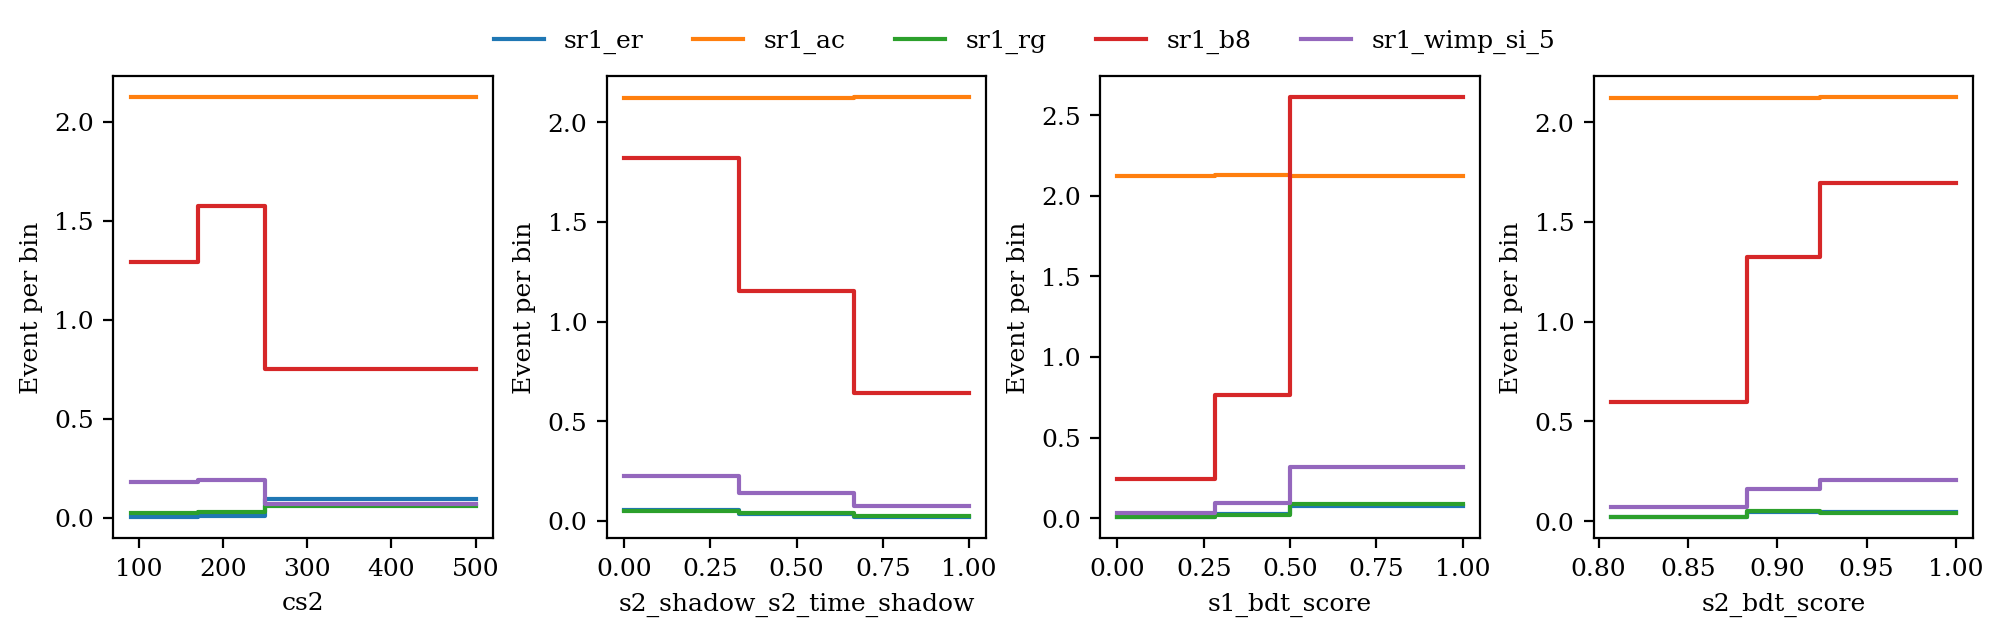

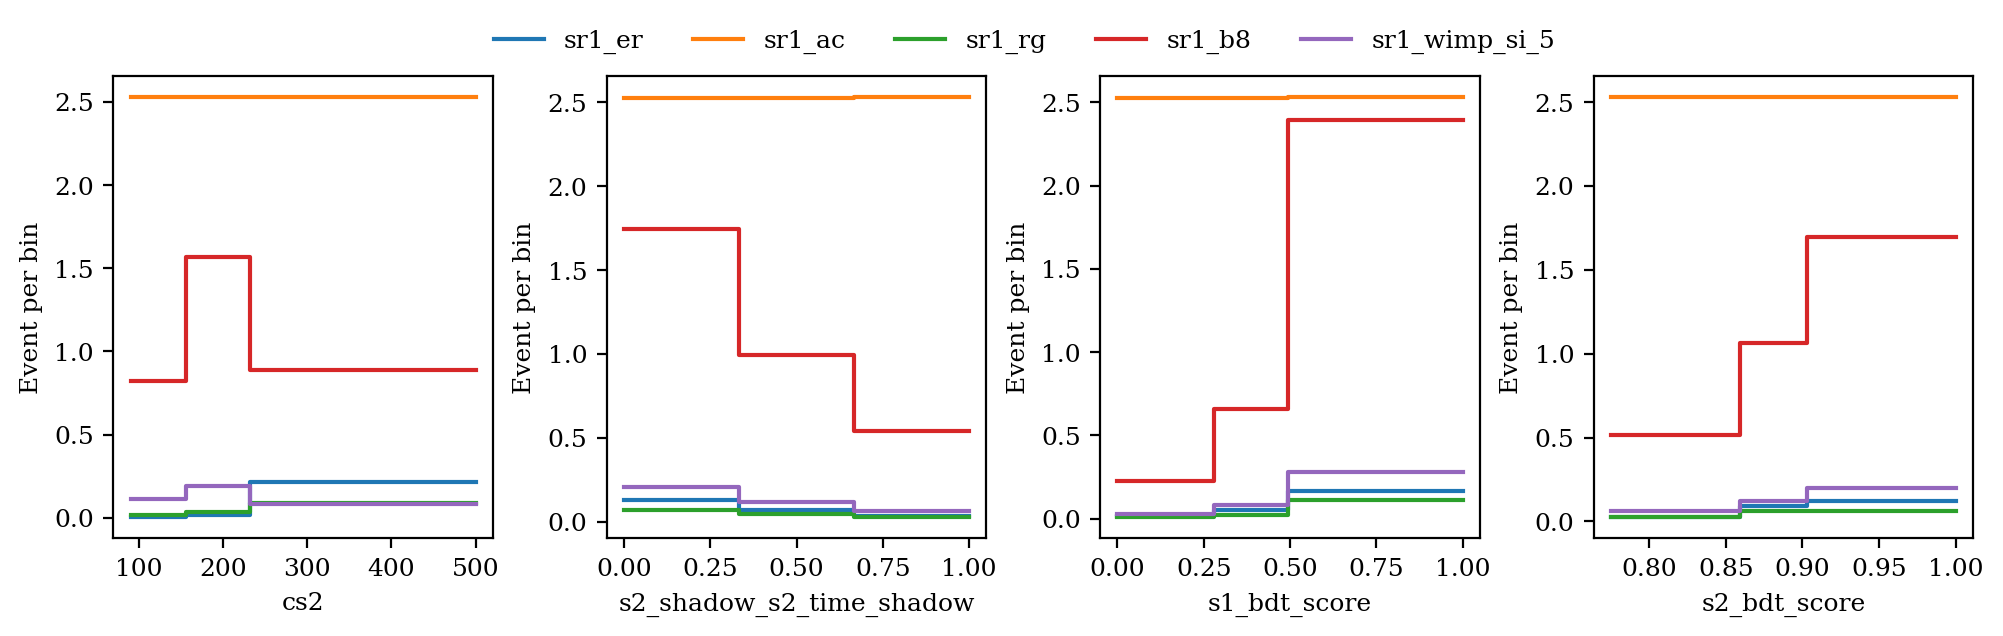

In [54]:
for sr in ['sr0', 'sr1']:
    fig = plt.figure(figsize=(12, 3))
    grid = plt.GridSpec(1, 4, wspace=0.3)
    
    for i, axis in enumerate(['cs2', 's2_shadow_s2_time_shadow', 's1_bdt_score', 's2_bdt_score']):
        for _source in sources[::-2]:
            source = _source[4:] # Removed sr0/sr1 heading.
            plt.subplot(grid[i])
            official_templates[sr+"_"+source].project(axis=axis).plot(label=_source)
        
        plt.xlabel(axis)
        plt.ylabel('Event per bin')

    plt.legend(loc='upper center', bbox_to_anchor=(-1.5, 1.15), ncol=5, frameon=False)
    plt.show()

In [12]:
# Initalize fast simulation object
template = Template()

# Load YBe yield model curve
yield_model = {
    'ly': load_json(os.path.join(data_path, "signal/ly_ybe_model_median.json")),
    'qy': load_json(os.path.join(data_path, "signal/qy_ybe_model_median.json"))
}

# Load fast-computed spectrum
wimp_spectrum = load_json(os.path.join(data_path, f"signal/wimp_si_spectrum_{wm}.json"))

0it [00:00, ?it/s]

0it [00:00, ?it/s]